# Review the Doc2Vec model trained on english wikipedia
The model is the one created by the notebook [train_d2v_model_on_wiki_data.ipynb](train_d2v_model_on_wiki_data.ipynb)

## Basic setup

### Import libraries

In [7]:
import pandas as pd
from pathlib import Path
from gensim.corpora.wikicorpus import  tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np


### Setup paths

In [8]:

data_folder = Path.cwd().parent / 'data'
documents_path=data_folder.parent.parent
MODEL_PATH=documents_path/'wiki-models'/'doc2vec-wiki-dm.model'
transformed_folder = data_folder / 'transformed'
BOOKS_PATH = Path(transformed_folder, "books_final.csv")
model_dm=Doc2Vec.load(str(MODEL_PATH))
book_df = pd.read_csv(BOOKS_PATH)


## Explore the model

In [9]:
#number of words in the model
len(model_dm.wv)

981209

In [10]:
#number of documents in the model
len(model_dm.dv)

5560040

### Try some word algebra with the model

In [11]:
sum_vector_queen=model_dm.wv["king"]+model_dm.wv["woman"]-model_dm.wv["man"]
# see the most similar word to this vector
model_dm.wv.most_similar(positive=[sum_vector_queen])

[('king', 0.7530036568641663),
 ('queen', 0.6644212603569031),
 ('woman', 0.5923677682876587),
 ('empress', 0.5898811221122742),
 ('emperor', 0.5851888060569763),
 ('monarch', 0.5539047122001648),
 ('princess', 0.534824788570404),
 ('prince', 0.5324152708053589),
 ('caliph', 0.4819503724575043),
 ('crown', 0.47747674584388733)]

Expected queen, but the results still make sense

In [27]:
model_dm.wv.most_similar(positive=[model_dm.wv["king"]])

[('king', 1.0),
 ('emperor', 0.7403579950332642),
 ('queen', 0.7385117411613464),
 ('prince', 0.7343108057975769),
 ('monarch', 0.6506686210632324),
 ('pope', 0.6075091361999512),
 ('duke', 0.6040611863136292),
 ('empress', 0.5915566682815552),
 ('sultan', 0.572464108467102),
 ('princess', 0.5634201765060425)]

In [12]:
sum_vector_german_food=model_dm.wv["sushi"]+model_dm.wv["germany"]-model_dm.wv["japan"]
model_dm.wv.most_similar(positive=[sum_vector_german_food])

[('sushi', 0.6159053444862366),
 ('germany', 0.5474534034729004),
 ('currywurst', 0.4936647415161133),
 ('konditorei', 0.4715989828109741),
 ('döner', 0.46854397654533386),
 ('krapfen', 0.46662649512290955),
 ('bratwurst', 0.45362746715545654),
 ('bockwurst', 0.44847220182418823),
 ('fassbrause', 0.446499228477478),
 ('mettwurst', 0.43930724263191223)]

## Test the model on the book descriptions

### Encode the book descriptions

In [13]:
#preprocess the documents
preprocessed_docs=[list(tokenize(doc)) for doc in book_df['description']]
new_vectors=[model_dm.infer_vector(doc) for doc in preprocessed_docs]

### Try to get the Harry Potter books recommended

In [14]:
sample_text="A book about an orphan boy who goes to a wizard boarding school"
preprocessed_text=tokenize(sample_text)
sample_vector=model_dm.infer_vector(preprocessed_text)

# Calculate the cosine similarity between the sample vector and each vector in new_vectors
similarities = cosine_similarity([sample_vector], new_vectors)[0]

# Get the indices of the vectors in descending order of similarity
most_similar_indices = similarities.argsort()[::-1]

# Get the top 5 most similar titles
most_similar_titles=book_df.iloc[most_similar_indices[:5]]['title']
# Get the top 5 similarities
most_similar_scores=similarities[most_similar_indices[:5]]
# Print the top 5 most similar titles with similarities
for title, score in zip(most_similar_titles, most_similar_scores):
    print(f"{title} with similarity {score:.2f}")

ساق البامبو with similarity 0.92
رباعيات صلاح جاهين with similarity 0.92
في ديسمبر تنتهي كل الأحلام with similarity 0.91
The Faraway Tree Stories with similarity 0.91
أولاد حارتنا with similarity 0.90


This doesn't make sense
### Exclude the non english descriptions

In [15]:
#get the indices of english books
english_books=book_df['language']=="English"
english_books_indices=book_df[english_books].index
#get the vectors of the english books
english_vectors=[new_vectors[i] for i in english_books_indices]
# Calculate the cosine similarity between the sample vector and each vector in english_vectors
similarities = cosine_similarity([sample_vector], english_vectors)[0]
# Get the indices of the vectors in descending order of similarity
most_similar_indices = similarities.argsort()[::-1]

# Get the top 5 most similar titles
most_similar_titles=book_df.iloc[most_similar_indices[:5]]['title']
# Get the top 5 similarities
most_similar_scores=similarities[most_similar_indices[:5]]
# Print the top 5 most similar titles with similarities
for title, score in zip(most_similar_titles, most_similar_scores):
    print(f"{title} with similarity {score:.2f}")

Season of Migration to the North with similarity 0.91
Start with Why: How Great Leaders Inspire Everyone to Take Action with similarity 0.90
Johnny Got His Gun with similarity 0.88
Demon Lord of Karanda with similarity 0.88
The Divergent Series 2-Book Collection with similarity 0.88


Better results but still not perfect
### Build the similarity matrix

In [16]:
similarity_matrix = cosine_similarity(new_vectors)

<Axes: ylabel='Count'>

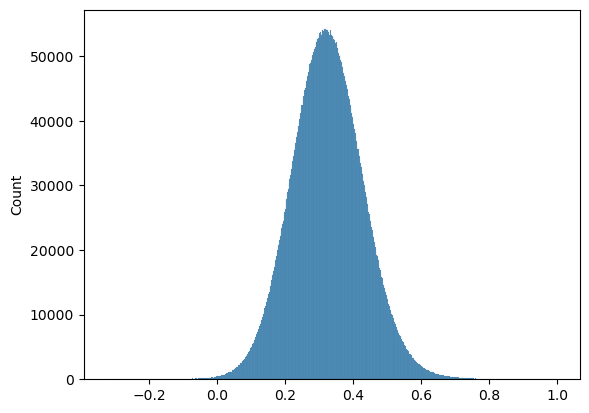

In [17]:
#get the upper triangle of the similarity matrix
upper_triangle = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=1)]
#plot the histogram
sns.histplot(upper_triangle)

## Visualize the similarities between languages
Since the model was only trained on english data, we can see how well it generalizes to other languages

### Group the indices of different languages

In [18]:
indices_for_language = {}
for language, group_df in book_df.groupby('language'):
    indices_for_language[language] = group_df.index.to_list()

### French and Indonesian

<Axes: >

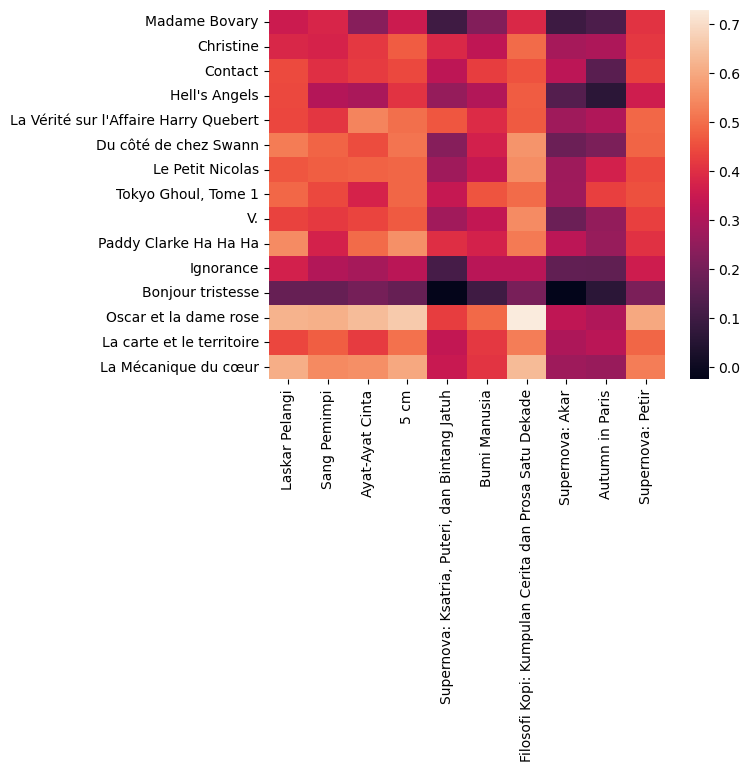

In [19]:
sim_french_indonesian = similarity_matrix[indices_for_language['French']][:, indices_for_language['Indonesian']]
sim_french_indonesian.shape
#make a heatmap
sns.heatmap(sim_french_indonesian,xticklabels=book_df.iloc[indices_for_language['Indonesian']]['title'],yticklabels=book_df.iloc[indices_for_language['French']]['title'])

### German and Arabic

<Axes: >

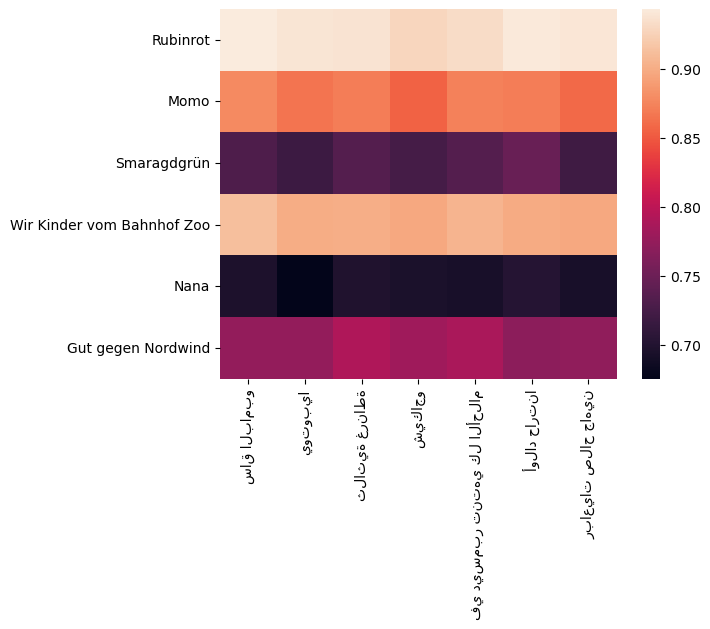

In [20]:
sim_german_arabic = similarity_matrix[indices_for_language['German']][:, indices_for_language['Arabic']]
#make a heatmap, with text on the axes
sns.heatmap(sim_german_arabic, xticklabels=book_df.iloc[indices_for_language['Arabic']]['title'], yticklabels=book_df.iloc[indices_for_language['German']]['title'])

In [21]:
#see the book Rubinrot
rubinrot=book_df[book_df['title']=="Rubinrot"]
rubinrot_idx=rubinrot.index[0]
#find the most similar books to Rubinrot
similarities = similarity_matrix[rubinrot_idx]
most_similar_indices = similarities.argsort()[::-1][:5]
most_similar_scores=similarities[most_similar_indices]
most_similar_books=book_df.iloc[most_similar_indices]
for title, score in zip(most_similar_books['title'], most_similar_scores):
    print(f"{title} with similarity {score:.2f}")

Rubinrot with similarity 1.00
Harry Potter Boxed Set, Books 1-5 with similarity 0.95
ساق البامبو with similarity 0.94
أولاد حارتنا with similarity 0.94
رباعيات صلاح جاهين with similarity 0.94


Print all arabic words and the words most similar to them

In [22]:
#print all arabic words and the words most similar to them
for index in indices_for_language['Arabic']:
    words=preprocessed_docs[index]
    #find the most similar word to each word
    for word in words:
        try:
            similar_words=model_dm.wv.most_similar(word)
            print("Current word: ", word)
            print("Most similar words: ", similar_words)
        except:
            continue

Current word:  كان
Most similar words:  [('ية', 0.6853411793708801), ('الكتب', 0.6801517009735107), ('فاف', 0.6777905225753784), ('لي', 0.6743801832199097), ('اض', 0.6710608005523682), ('سلام', 0.6596665382385254), ('چه', 0.657252848148346), ('كه', 0.6534430384635925), ('لم', 0.6518284678459167), ('الطبعة', 0.643781304359436)]
Current word:  تحت
Most similar words:  [('منتخب', 0.6552067995071411), ('القدم', 0.6462112665176392), ('لكرة', 0.6331778764724731), ('مصر', 0.5934224724769592), ('على', 0.5848439931869507), ('الاتحاد', 0.5820387005805969), ('دار', 0.579319953918457), ('فوق', 0.5753750205039978), ('فى', 0.5739369988441467), ('عن', 0.5715585947036743)]
Current word:  أن
Most similar words:  [('إلا', 0.6261513829231262), ('الكتب', 0.624104380607605), ('نام', 0.6189962029457092), ('ية', 0.6161732077598572), ('الرحمن', 0.6128612756729126), ('ام', 0.6126580238342285), ('أو', 0.6086500287055969), ('اض', 0.6078717708587646), ('قبل', 0.6071790456771851), ('روح', 0.6034857630729675)]
Curr

Print all german words and words most similar to them

In [23]:
for index in indices_for_language["German"]:
    words=preprocessed_docs[index]
    #find the most similar word to each word
    for word in words:
        try:
            similar_words=model_dm.wv.most_similar(word)
            print("Current word: ", word)
            print("Most similar words: ", similar_words)
        except:
            continue

Current word:  manchmal
Most similar words:  [('böses', 0.5879787802696228), ('herzschlag', 0.5813449621200562), ('liebt', 0.5690546631813049), ('vielleicht', 0.568541944026947), ('irgendwie', 0.5674859881401062), ('schlafen', 0.5641320943832397), ('einsam', 0.5614822506904602), ('spendierhosen', 0.5592460632324219), ('küssen', 0.5545241236686707), ('träumen', 0.5498257279396057)]
Current word:  ist
Most similar words:  [('wir', 0.5851993560791016), ('nicht', 0.5782618522644043), ('wird', 0.565278172492981), ('sie', 0.5601643919944763), ('ich', 0.5531861782073975), ('auf', 0.5450968146324158), ('sind', 0.543207049369812), ('ltfm', 0.5364665985107422), ('alles', 0.5281522274017334), ('geht', 0.5250816941261292)]
Current word:  es
Most similar words:  [('um', 0.6282699108123779), ('tu', 0.6007959842681885), ('ar', 0.5998141765594482), ('dar', 0.5931410789489746), ('sl', 0.5820596218109131), ('af', 0.5778688788414001), ('ein', 0.5755115747451782), ('se', 0.5707206130027771), ('er', 0.5676

### Japanese and Italian

c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from current font.
  fig.canvas.draw()
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 23569 (\N{CJK UNIFIED IDEOGRAPH-5C11}) missing from current font.
  fig.canvas.draw()
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from current font.
  fig.canvas.draw()
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from current font.
  fig.canvas.draw()
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  fig.canvas.draw()
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\seaborn\ut

<Axes: >

c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from current font.
  func(*args, **kwargs)
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 23569 (\N{CJK UNIFIED IDEOGRAPH-5C11}) missing from current font.
  func(*args, **kwargs)
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from current font.
  func(*args, **kwargs)
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from current font.
  func(*args, **kwargs)
c:\Users\Eleonora\anaconda3\envs\dipomska\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  func(*args, **kwargs)
c:\Users\Eleonora\an

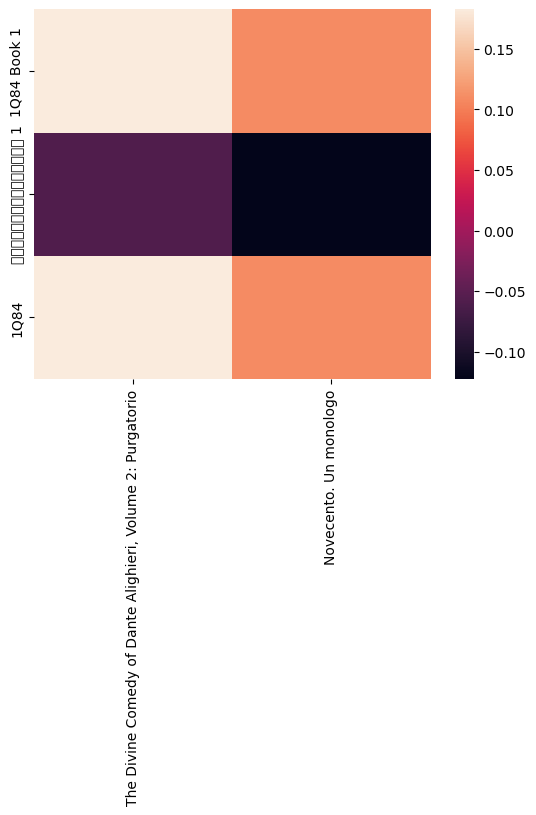

In [24]:
sim_japanese_italian = similarity_matrix[indices_for_language['Japanese']][:, indices_for_language['Italian']]
#make a heatmap
sns.heatmap(sim_japanese_italian, xticklabels=book_df.iloc[indices_for_language['Italian']]['title'], yticklabels=book_df.iloc[indices_for_language['Japanese']]['title'])

In [25]:
#print all japanese books and words most similar to them
for index in indices_for_language['Japanese']:
    words=preprocessed_docs[index]
    #find the most similar word to each word
    for word in words:
        try:
            similar_words=model_dm.wv.most_similar(word)
            print("Current word: ", word)
            print("Most similar words: ", similar_words)
        except:
            continue

### English and Indonesian

<Axes: >

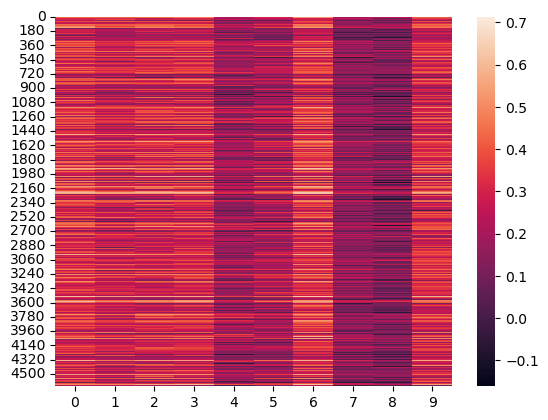

In [26]:
sim_english_indonesian = similarity_matrix[indices_for_language['English']][:, indices_for_language['Indonesian']]
#make a heatmap
sns.heatmap(sim_english_indonesian)

### Conclusion
For most of the languages, the similarities make sense, but for arabic, the model gives unusually high similarities with german documents
. I'm not going to use this model in the content based filtering.